# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data

In [3]:
train_x = np.linspace(0, 1, 58)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((58,), (58, 3))

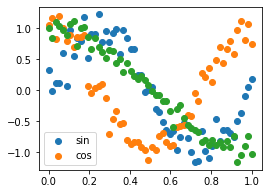

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["sin", "cos"])

In [6]:
x = train_x
xx = np.concatenate((x, x, x), axis=0)[:,None]
n = len(x)
idx2 = np.ones(n) + 1
idx = np.concatenate((np.zeros(n), np.ones(n), idx2))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((train_y[:,0], train_y[:,1], train_y[:,2]))
x.shape, X.shape, y.shape

((58,), (174, 2), (174,))

### Pymc model

In [7]:
X.shape, y.shape

((174, 2), (174,))

In [9]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=2, beta=0.5)
    cov2 = eta**2 * pm.gp.cov.Matern32(2, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    W2 = pm.Normal("W2", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa2 = pm.Gamma("kappa2", alpha=1.5, beta=1, shape=3)
    coreg2 = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa2, W=W2)
    
    cov_func1 = pm.gp.cov.Prod([coreg, cov])
    cov_func2 = pm.gp.cov.Prod([coreg2, cov2])
    cov_func = pm.gp.cov.Add([cov_func1, cov_func2])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

In [10]:
# with model:
#     cov_func2 = pm.gp.cov.Kron([coreg, cov])

In [11]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, W2, kappa2, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 304 seconds.


CPU times: user 14min 29s, sys: 25min 55s, total: 40min 25s
Wall time: 5min 14s


In [12]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new, x_new), axis=0)
idx2 = np.ones(200) + 1
idx2 = np.concatenate((np.zeros(200), np.ones(200), idx2))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [13]:
X_new.shape

(600, 2)

In [14]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

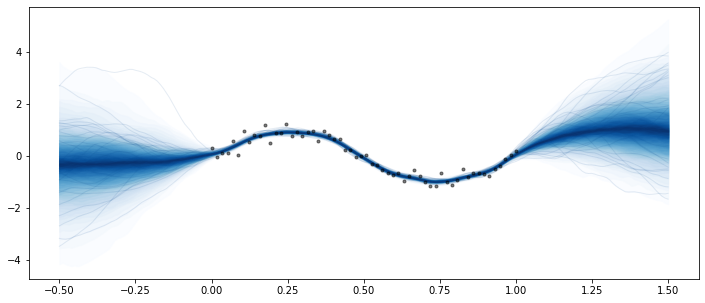

In [15]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

(-4.0, 4.0)

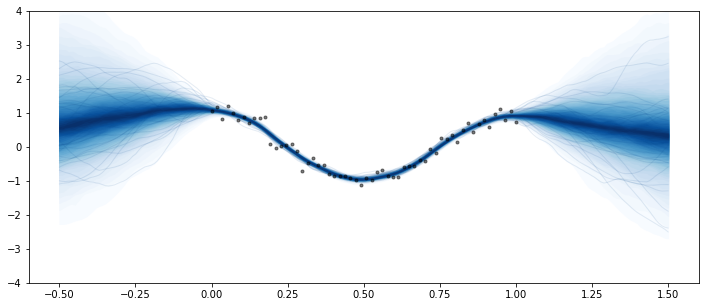

In [16]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,200:400], X_new[200:400,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

(-4.0, 4.0)

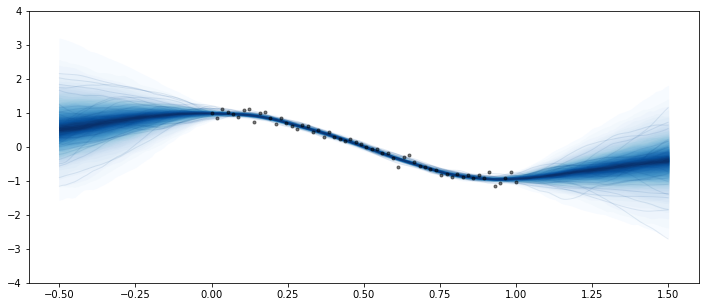

In [17]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,400:], X_new[400:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [18]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.159,3.023,-5.755,5.456,0.149,0.136,417.0,326.0,NaN
"W[0, 1]",0.166,2.715,-4.197,5.891,0.149,0.106,331.0,292.0,NaN
"W[1, 0]",0.123,3.490,-5.978,7.055,0.187,0.147,346.0,298.0,NaN
"W[1, 1]",0.051,3.162,-4.760,5.549,0.153,0.124,430.0,415.0,NaN
"W[2, 0]",0.020,2.685,-5.651,4.567,0.132,0.106,418.0,432.0,NaN
"W[2, 1]",0.019,2.717,-5.003,4.589,0.176,0.124,250.0,332.0,NaN
"W2[0, 0]",0.080,3.339,-5.623,5.898,0.231,0.164,210.0,317.0,NaN
"W2[0, 1]",0.140,3.445,-5.946,6.138,0.208,0.147,281.0,314.0,NaN
"W2[1, 0]",0.013,2.778,-4.760,5.231,0.195,0.138,193.0,169.0,NaN
"W2[1, 1]",-0.289,2.701,-6.028,4.278,0.171,0.121,254.0,333.0,NaN


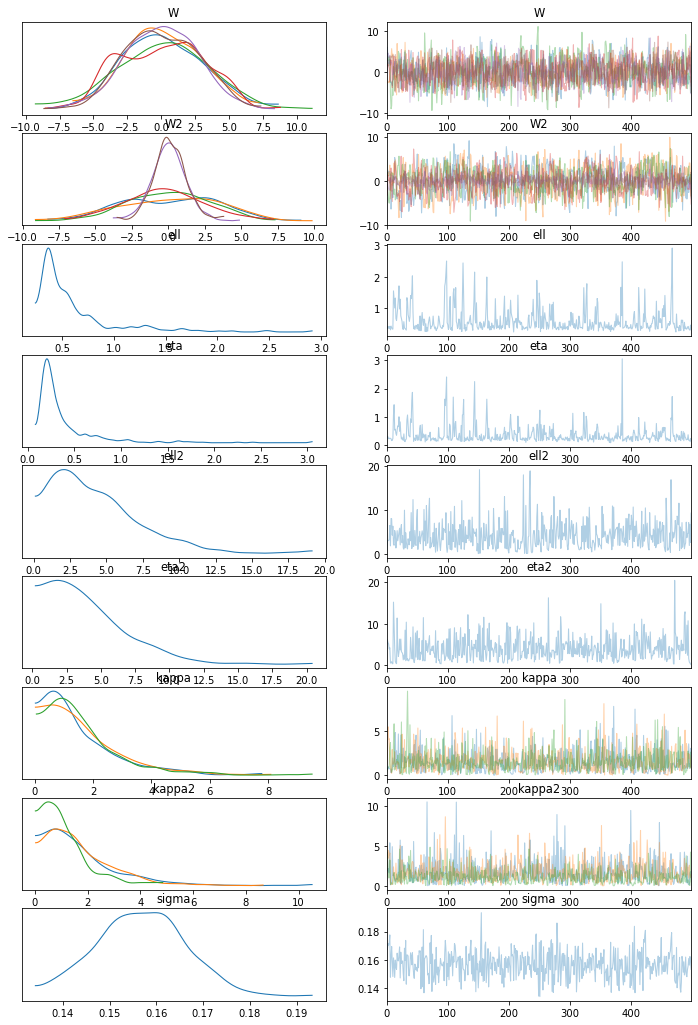

In [19]:
az.plot_trace(gp_trace);